# Image recognition on reservoir computing

1. Overview
2. Purpose
3. Preparation
4. Implementation
  - Extension of input module for row-wise input
  - Building MNIST datasets by sampling ESN dynamics
5. Demonstration

# 1. Overview

There are several ways to convert a single image with size $(W, H)$ into input time-series data.
The most commonly-used approach would be **row-wise** or **column-wise** conversion, where each row works as $W$- or $H$- dimensional input vector for $H$ and $W$ time steps, respectively. 
You can find this approach in several reservoir computing papers (*e. g.,* [N. Schaetti *et al.*, 2016](https://ieeexplore.ieee.org/document/7982291)). 
Another approach is pixel-wise one where a single image is converted to a 1-dimensional time-series signal of $W \times H$ time steps, which was, for example, introduced in [G. Bellec *et al.*, 2018](https://proceedings.neurips.cc/paper/2018/hash/c203d8a151612acf12457e4d67635a95-Abstract.html).
In addition, the full-image presentation shown in [P. Antonik *et al.*, 2019](https://ieeexplore.ieee.org/document/8744568) is one of the simplest options where a single image is reshaped as a $W \times H$-dimensional constant vector and inputted for a several time step.

In this notebook, let's implement a *row-wise* approach and verify how successfully a simple ESN can learn the MNIST database.

# 2. Purpose
Implementing classification setups using reservoir computing setups via **MNIST database** and understanding **how RNN and physical setups** can be extended for **image recognition task**.

This notebook includes implementations of
- Extension of input module for the row-wise approach
- Building MNIST datasets by sampling ESN dynamics 

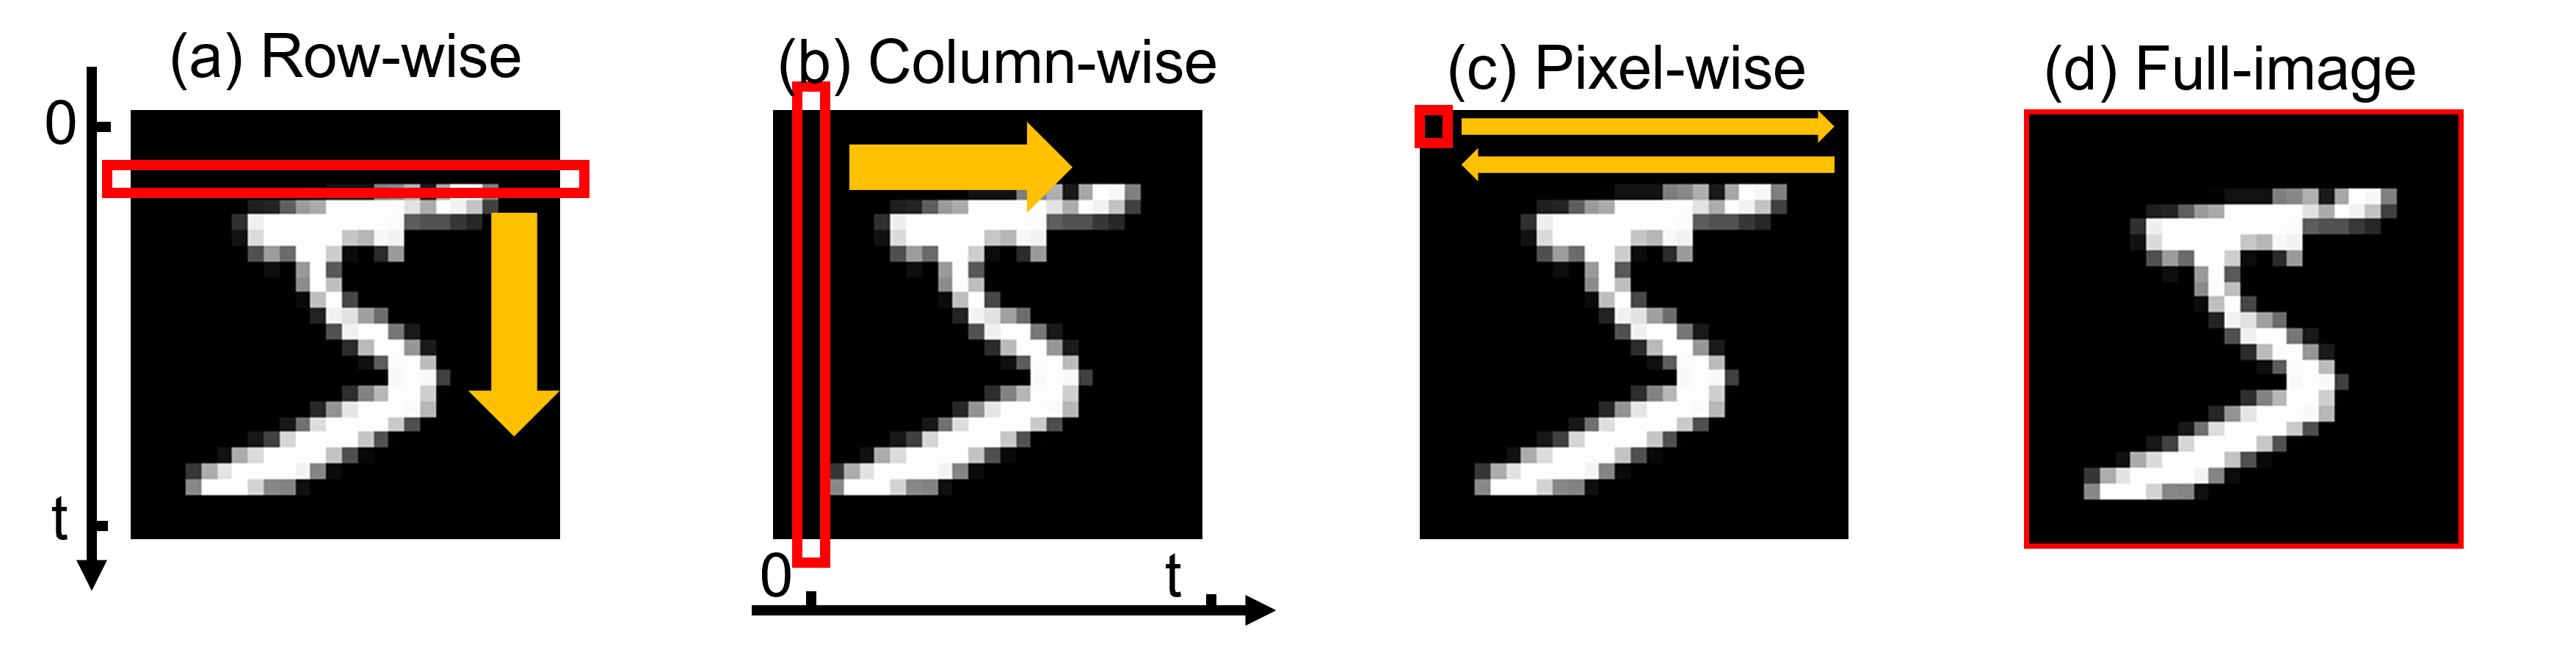

# 3. Preparation

In [ ]:
import sys
import math
import numpy as np

import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
if "google.colab" in sys.modules:
    from google.colab import drive  # Connecting to google drive
    drive.mount("/content/gdrive")
    %cd /content/gdrive/My Drive/sandbox/rc_tutorial/classification_task/
    # NOTE: change it to your own path
    # e.g., %cd /content/gdrive/My Drive/[PATH_TO_NOTEBOOK]
    from utils.magic import colab_script  # save and load cells
    exec(colab_script)
else:
    sys.path.append(".")
    from utils.magic import run_and_save, load_and_run  # save and load cells
    
from utils.tqdm import trange  # progress bar
from views.esn_mnist import *  # visualization wrapper
from tests.esn_mnist import *  # check function

# 4. Implementation
## 4.1 Extension of input module for Row-wise input

Here, let's implement the row-wise approach. 
Suppose we have an image $I \in \mathbb{R}^{H \times W}$.
In the row-wise approach, each $t$-th row of input image $I_t$ works as time series $\boldsymbol{r}(t) \in \mathbb{R}^{W}$. 
The rest process is almost the same as the previous ones.
Let's prepare the following discrite  and linear weight $W_\text{in} \in \mathbb{R}^{D \times W}$ to produce input vector;
$$
\def\bm#1{{\boldsymbol #1}}
\begin{align*}
\\
\bm{x}(t+1) &= \tanh\left(g W^\text{net} \bm{x}(t) + W_\text{in}\bm{r}(t)\right), \\ 
\\
\\
\end{align*}
$$
where $\tanh$ is an element-wise nonlinear activation function, the constant value $g$ controls the strength of nonlinearity, $W^\text{net} \in \mathbb{R}^{D \times D}$ is a random matrix sampled from Gaussian distribution whose spectral radius is normalized to 1 ($\rho(W^{\text{net}})=1$), and weight $W^\text{in} \in \mathbb{R}^{2 \times D}$ is sampled from the uniform distribution $\mathcal{U}([-\sigma_\text{in}, \sigma_\text{in}])$.
The length of input time-series data is $H$.
Hence, the reservoir state $\bm{x}(t)$ could be written in the form of nonlinear mapping from the initial state $\bm{x}(0)$ and the image $I$.
In this notebook, we set $\bm{x}(0)$ to 0 for simplicity and try the softmax regression based on $\bm{x}(t)~(t=1,\cdots, H)$.

Here, let's implement the `Linear` and `ESN`.

<details>
<summary>
Hints
</summary>

- Use `self.rnd.uniform` to initialize the matrix.
- Use `np.dot` or `np.matmul` for `Linear.predict`.
- Use `np.asarray` is convinient to pre-process the argument.
- $\rho({W^\text{net}})$ is efficiently calculated by [`scipy.sparse.linalg.eigs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html).
    - Specify three options `return_eigenvectors`, `k`, and `which`.
    - Since the obtained eigenvalue can be a complex number, convert it into a real one by `abs`.
- Use `np.dot` or `np.matmul` for `ESN.step`.
- Since `x` can be multi-dimensional, $\bm{x}^T W^T$ is preferable instead of calculate $W \bm{x}$.
    - Use `np.swapaxes` or `x.T` to realize it.

In [ ]:
%%run_and_save ./answer/echo_state_network.py

try:
    from scipy.sparse.linalg.eigen.arpack import eigs, ArpackNoConvergence
except Exception:
    from scipy.sparse.linalg import eigs, ArpackNoConvergence


class Module(object):
    def __init__(self, *args, seed=None, dtype=np.float64, **kwargs):
        self.rnd = np.random.RandomState(seed)
        self.dtype = dtype


class Linear(Module):
    def __init__(self, input_dim, output_dim, bound=None, **kwargs):
        '''
        Linear model

        Args:
            input_dim (int): input node dim.
            output_dim (int): output node dim.
        '''
        super(Linear, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        if bound is None:
            bound = math.sqrt(1 / output_dim)
        # TODO initialize self.w by using self.rnd.uniform
        ...

    def __call__(self, x):
        return self.predict(x)

    def predict(self, x):
        y = ... # TODO
        return y


class ESN(Module):
    def __init__(
            self, dim, f=np.tanh, g=1.0, a=None, p=1.0,
            bias=None, init_state=None, normalize=True, **kwargs):
        '''
        Echo state network [Jaeger, H. (2001). Bonn, Germany: German National Research Center for Information Technology GMD Technical Report, 148(34), 13.]

        Args:
            dim (int): number of the ESN nodes
            f (func, optional): activation function. Defaults to np.tanh.
            g (float, optional): nonlinear coefficient. Defaults to 1.0.
            a (float, optional): leaky rate. Defaults to None.
            p (float, optional): density of connection matrix. Defaults to 1.0.
            bias (optional): bias term. Defaults to None.
            init_state (optional): initial states. Defaults to None.
            normalize (bool, optional): normalizing connection matrix. Defaults to True.
        '''
        super(ESN, self).__init__(**kwargs)
        self.dim = dim
        self.f = f  # activation function 
        self.g = g  # nonlinearity
        self.p = p  # matrix density
        self.a = a  # leaky rate
        self.bias = bias  # bias term
        if init_state is None:  # initial values
            self.x_init = np.zeros(dim, dtype=self.dtype)
        else:
            self.x_init = np.array(init_state, dtype=self.dtype)
        self.x = np.array(self.x_init)

        # generating normalzied sparse matrix (p: density prob.)
        while True:
            try:
                coeff = 1.0 / np.sqrt(self.dim * self.p) # circular law
                self.w_net = self.rnd.randn(self.dim, self.dim).astype(self.dtype) * coeff
                w_con = np.full((dim * dim,), False)
                w_con[:int(dim * dim * self.p)] = True
                self.rnd.shuffle(w_con)
                w_con = w_con.reshape((dim, dim))
                self.w_net = self.w_net * w_con  # sparse matrix
                if normalize:
                    eigen_values = ... # TODO
                    spectral_radius = ... # TODO
                    self.w_net = ... # TODO
                break
            except ArpackNoConvergence:
                continue

    def step(self, u=None):
        x_in = ... # TODO
        if u is not None:
            x_in += u
        if self.bias is not None:
            x_in += self.bias
        if self.a is None:
            self.x = self.f(x_in)
        else:
            self.x = (1 - self.a) * self.x + self.a * self.f(x_in)

    def step_while(self, num_step, **kwargs):
        for _ in range(num_step):
            self.step(**kwargs)

In [ ]:
test_linear(Linear)

In [ ]:
test_esn(ESN)

Check if ESN is successfully normalized (cf. [Circular law](https://en.wikipedia.org/wiki/Circular_law)).

In [ ]:
%matplotlib inline

def show_eigen(mat):
    assert mat.ndim == 2
    assert mat.shape[0] == mat.shape[1]
    ts = np.linspace(0, 2 * np.pi, 100001)
    es = np.linalg.eigvals(mat)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(np.real(es), np.imag(es), s=1.0)
    ax.plot(np.cos(ts), np.sin(ts), lw=1.0, ls=":", color="k")
    
net = ESN(500, g=1.0)
show_eigen(net.w_net)

Also, we can reuse the `softmax`, `cross_entroy`, and `SoftmaxRegression` you have implemented in `softmax_regression.ipynb` (you do not need to do anything here).

In [ ]:
%load_and_run ./answer/softmax.py
%load_and_run ./answer/cross_entropy.py
%load_and_run ./answer/softmax_regression.py

# 4.2 Sampling ESN dynamics
Next, sample and observe the ESN dynamics when inputting an image.
First, load the MNIST database.

In [ ]:
%matplotlib inline

from torchvision.datasets import MNIST

class_num = 10
img_h, img_w = 28, 28

D_train = MNIST("./data", train=True, download=True,)
D_eval = MNIST("./data", train=False, download=True,)


def convert(D):
    X, Y = D.data.numpy(), D.targets.numpy()
    X = np.array(X / 255.0, dtype=np.float64).reshape(X.shape[0], -1)
    Y = np.array(Y, dtype=np.uint8)
    Y = np.eye(10)[Y]
    return X, Y


X_train, Y_train = convert(D_train)
X_eval, Y_eval = convert(D_eval)

print(X_train.shape, Y_train.shape, X_eval.shape, Y_eval.shape)

fig = show_dataset(X_train, Y_train, class_num, (28, 28))

The following function `emulate` samples ESN's dynamics when an MNIST image $I$ is given.
Please fill the following blank to realize **row-wise** input. 

<details>
<summary>
Hints
</summary>

- The shape of `img` is `(..., H, W)`.
- Use `[..., :, :]` or `[Ellipsis, :, :]` for matrix slicing. 

In [ ]:
def emulate(img, w_in, net, T=None):
    assert img.ndim >= 2  # input should be high dimensional
    record = {}
    if T is None:
        T = ... # TODO image_shape: (..., H, W), H is total time step here
    record["img"] = img
    record["u"] = np.zeros((T, *net.x.shape))
    record["x"] = np.zeros((T, *net.x.shape))
    for idx in range(T):
        r = ... # TODO
        u = ... # TODO
        ... # TODO use net.step
        record["x"][idx] = net.x
        record["u"][idx] = u
    return record

Then, let's build an ESN setup.

In [ ]:
bound = 1.0
esn_dim = 100
g = 0.9

w_in = Linear(img_w, esn_dim, bound=bound)
net = ESN(esn_dim, g=g, a=None)

Check if the code properly works by visualizing the dynamics.
The following codes visualize the ESN dynamics for images "0", "3", and "8".

In [ ]:
%matplotlib inline

for idx in [0, 3, 8]:
    img = X_train[Y_train[:, idx] == 1][0]
    net.x = np.zeros(net.x.shape)  # x set to 0
    record = emulate(img.reshape(img_h, img_w), w_in, net)
    fig = show_dynamics(record)

# 5. Demonstration

Now, it's time to solve MNIST with ESN setups.
We use the same codes in `softmax_regression.ipynb`

In [ ]:
%load_and_run ./answer/training.py

Prepare a non-chaotic DESN with 100 nodes ($N=100, g=0.9$).

The initialization bound value of $\sigma_\text{in}$ is set to $1$.
Note that the `model_dim` of `SoftmaxRegression` is `img_h * esn_dim` for utilizing all trajectories within the range ($t = 1, \cdots H$) as a single state.

In [ ]:
bound = 1.0
esn_dim = 100
g = 0.9

w_in = Linear(img_w, esn_dim, bound=bound)
net = ESN(esn_dim, g=g, a=None)
model = SoftmaxRegression(img_h * esn_dim, class_num)

Instead of using `X_train` and `X_eval`, sample ESN states $[\bm{x}(1), \cdots, \bm{x}(H)]$ for each image and contruct `X_esn_train` and `X_esn_eval` whose shapes are `(60000, H * esn_dim)`, `(10000, H * esn_dim)`, respectively.

In [ ]:
def create_dataset(w_in, net, X, batch_size=100):
    data_size = X.shape[0]
    X_esn = np.zeros((data_size, img_h * net.dim))
    for idx in trange(0, data_size, batch_size):
        x = X[idx:idx+batch_size]
        img = x.reshape(-1, img_h, img_w)
        net.x = np.zeros((img.shape[0], net.dim))
        record = emulate(img, w_in, net)
        rec_x = record["x"].transpose((1, 0, 2))  # (H, N, W) to (N, H, W)
        # to (N, H * W)
        X_esn[idx:idx+batch_size] = rec_x.reshape(img.shape[0], -1)
    return X_esn


X_esn_train = create_dataset(w_in, net, X_train)
X_esn_eval = create_dataset(w_in, net, X_eval)

print(X_esn_train.shape, X_esn_eval.shape)

Finally, let's tune the model parameters based on the constructed dataset.
After obtaining the result, let's compare it with the previous results in `softmax_regression.ipynb` and confirm the RC model outperforms the vanilla one.

In [ ]:
%matplotlib inline

n_epoch = 20
batch_size = 100
lr = 0.1
record = train_model(
    model, X_esn_train, Y_train, X_esn_eval, Y_eval,
    n_epoch=n_epoch, batch_size=batch_size, lr=lr)
fig = show_progress(record)

# Advanced topics

- Try the other image datasets
  - [Cifar10/100](https://www.cs.toronto.edu/~kriz/cifar.html)
  - [ImageNet](https://www.image-net.org/)
  - *etc*.
- Increase the training epochs to get better performances
- Improve the learning algorithm
  - [Various types of optimizing algorithms](https://ruder.io/optimizing-gradient-descent/)
- Design different RNN architectures
  - Deep reservoir
  - Parallel reservoir
  - Ring topology (cf. Optical reservoir)
  - *etc*.